**Siamese Network One-Shot**

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import  numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv('reference_subset_1.csv')
labels = df['Label'].values
raw_specs = df.drop(columns=['Label']).values.astype(float)

In [25]:
lam, p, niter = 1e4, 0.01, 10
def baseline_als(y):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, s in enumerate(arr):
        b = baseline_als(s)
        c = s - b
        norm = np.linalg.norm(c)
        out[i] = c / norm if norm > 0 else c
    return out

In [26]:
spectra = preprocess(raw_specs)

In [27]:
def augment(spec, noise_std=0.01, shift_max=2):
    spec_noisy = spec + np.random.normal(0, noise_std, size=spec.shape)
    shift = np.random.randint(-shift_max, shift_max + 1)
    return np.roll(spec_noisy, shift)

# 3. Pair dataset for contrastive learning
class RamanPairDataset(Dataset):
    def __init__(self, specs, labels, augment_fn=None):
        self.specs = specs
        self.labels = labels
        self.augment = augment_fn
        self.by_label = {c: np.where(labels == c)[0] for c in np.unique(labels)}

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        x1 = self.specs[idx]
        y1 = self.labels[idx]
        if np.random.rand() < 0.5:
            j = np.random.choice(self.by_label[y1])
            label = 1.0
        else:
            neg = [c for c in self.by_label if c != y1]
            y2 = np.random.choice(neg)
            j = np.random.choice(self.by_label[y2])
            label = 0.0
        x2 = self.specs[j]
        if self.augment:
            x1 = self.augment(x1)
            x2 = self.augment(x2)
        return (torch.tensor(x1, dtype=torch.float32).unsqueeze(0),
                torch.tensor(x2, dtype=torch.float32).unsqueeze(0),
                torch.tensor(label, dtype=torch.float32))

# 4. Siamese network definition
class SiameseNet(nn.Module):
    def __init__(self, input_len, embed_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_len // 4) * 32, embed_dim),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encoder(x)
        return F.normalize(z, dim=1)

# 5. Contrastive loss
def contrastive_loss(z1, z2, label, margin=1.0):
    dist = F.pairwise_distance(z1, z2)
    loss_pos = label * dist**2
    loss_neg = (1 - label) * F.relu(margin - dist)**2
    return (loss_pos + loss_neg).mean()

In [28]:
input_len = spectra.shape[1]
dataset = RamanPairDataset(spectra, labels, augment_fn=augment)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
model = SiameseNet(input_len, embed_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(100):
    total_loss = 0.0
    for x1, x2, lbl in loader:
        z1, z2 = model(x1), model(x2)
        loss = contrastive_loss(z1, z2, lbl)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x1.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "siamese_raman.pth")

Epoch 1, Loss: 0.3580
Epoch 2, Loss: 0.5408
Epoch 3, Loss: 0.4859
Epoch 4, Loss: 0.4933
Epoch 5, Loss: 0.4541
Epoch 6, Loss: 0.3619
Epoch 7, Loss: 0.5418
Epoch 8, Loss: 0.3641
Epoch 9, Loss: 0.3546
Epoch 10, Loss: 0.1430
Epoch 11, Loss: 0.1371
Epoch 12, Loss: 0.1253
Epoch 13, Loss: 0.1876
Epoch 14, Loss: 0.1264
Epoch 15, Loss: 0.1084
Epoch 16, Loss: 0.0877
Epoch 17, Loss: 0.0934
Epoch 18, Loss: 0.0356
Epoch 19, Loss: 0.0962
Epoch 20, Loss: 0.0533
Epoch 21, Loss: 0.0367
Epoch 22, Loss: 0.0636
Epoch 23, Loss: 0.0699
Epoch 24, Loss: 0.0973
Epoch 25, Loss: 0.0369
Epoch 26, Loss: 0.0800
Epoch 27, Loss: 0.0699
Epoch 28, Loss: 0.0350
Epoch 29, Loss: 0.0681
Epoch 30, Loss: 0.0744
Epoch 31, Loss: 0.0879
Epoch 32, Loss: 0.0737
Epoch 33, Loss: 0.0501
Epoch 34, Loss: 0.0699
Epoch 35, Loss: 0.0898
Epoch 36, Loss: 0.0773
Epoch 37, Loss: 0.0723
Epoch 38, Loss: 0.0613
Epoch 39, Loss: 0.0453
Epoch 40, Loss: 0.0569
Epoch 41, Loss: 0.0732
Epoch 42, Loss: 0.0353
Epoch 43, Loss: 0.0854
Epoch 44, Loss: 0.02

Top-1 Accuracy: 100.00%
Top-2 Accuracy: 100.00%


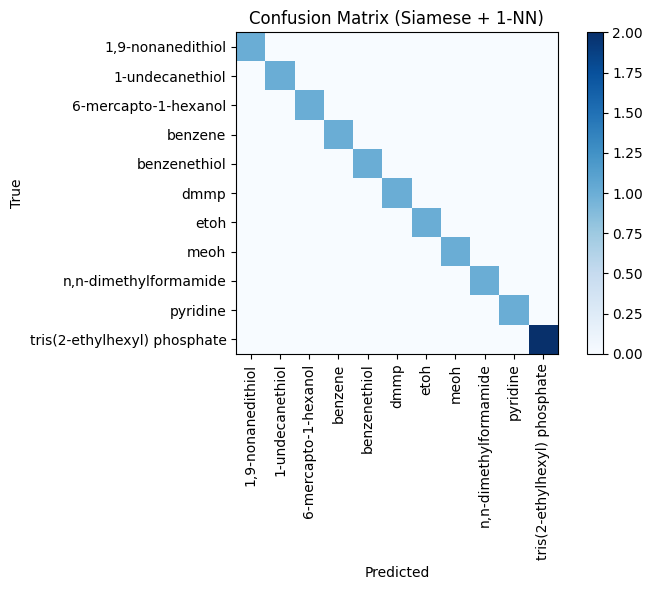

In [29]:
ref_df = pd.read_csv('reference_siamese.csv')
qry_df = pd.read_csv('query_siamese.csv')
if 'Label' not in ref_df.columns:
    ref_df.rename(columns={'Species': 'Label'}, inplace=True)
if 'Label' not in qry_df.columns:
    qry_df.rename(columns={'Species': 'Label'}, inplace=True)

wav_cols = ref_df.columns[:-1]
# numeric convert to ensure ordering
wav_cols = [col for col in wav_cols]
ref_specs = ref_df[wav_cols].values.astype(float)
qry_specs = qry_df[wav_cols].values.astype(float)
ref_labels = ref_df['Label'].values
qry_labels = qry_df['Label'].values

# 4. Preprocess spectra
ref_proc = preprocess(ref_specs)
qry_proc = preprocess(qry_specs)

# 5. Instantiate and load model
input_len = ref_proc.shape[1]
model = SiameseNet(input_len, embed_dim=64)
model.load_state_dict(torch.load("siamese_raman.pth"))
model.eval()

# 6. Compute embeddings
with torch.no_grad():
    ref_embeds = model(torch.tensor(ref_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()
    qry_embeds = model(torch.tensor(qry_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()

# 7. Nearest neighbor classification
pred1 = []
pred2 = []
for qz in qry_embeds:
    # compute distances
    dists = np.linalg.norm(ref_embeds - qz, axis=1)
    # sort ascending
    idxs = np.argsort(dists)
    pred1.append(ref_labels[idxs[0]])
    if len(idxs) > 1:
        pred2.append((ref_labels[idxs[0]], ref_labels[idxs[1]]))
    else:
        pred2.append((ref_labels[idxs[0]], None))

# 8. Compute accuracy
acc1 = accuracy_score(qry_labels, pred1)
acc2 = np.mean([qry_labels[i] in pair for i, pair in enumerate(pred2)])

print(f"Top-1 Accuracy: {acc1:.2%}")
print(f"Top-2 Accuracy: {acc2:.2%}")

# 9. Confusion matrix
labels_unique = np.unique(qry_labels)
cm = confusion_matrix(qry_labels, pred1, labels=labels_unique)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=90)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Confusion Matrix (Siamese + 1-NN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()